Mount to drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Imports.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn import metrics
!pip install datasets
from datasets import load_dataset, Image, Dataset, DatasetDict, load_metric
!pip install transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import torch
from transformers.trainer_utils import EvalPrediction
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

Load test set.

In [ ]:
test_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/test.csv')

X_test = []
y_test = []

for i in range(len(test_df)):
    img = cv.imread(test_df['path'][i])

    X_test.append(np.array(img))
    y_test.append(test_df['label'][i])

X_test = np.array(X_test)
y_test = np.array(y_test)

## VGG-16

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model')

In [ ]:
test_x = tf.keras.utils.normalize(X_test, axis=1)
predictions = model.predict(test_x, verbose=True)
predictions = np.where(predictions > .5, 1, 0)

19/19 [==============================] - 13s 217ms/step


In [ ]:
score = model.evaluate(test_x, y_test, verbose=1)

19/19 [==============================] - 3s 124ms/step - loss: 0.1354 - acc: 0.9633


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       313
           1       0.95      0.98      0.96       287

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



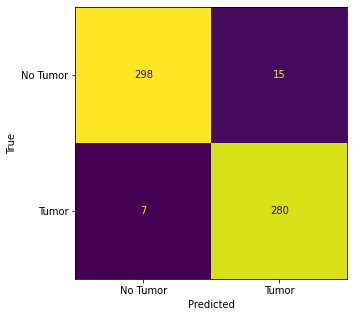

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)

## VGG-16 (Histogram equalization)

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal')

In [ ]:
test_x_he = []
for img in X_test:
    img_grayScaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_equ = cv.equalizeHist(img_grayScaled)
    img_final = cv.cvtColor(img_equ, cv.COLOR_GRAY2BGR)

    test_x_he.append(img_final)

In [ ]:
test_x_he = tf.keras.utils.normalize(test_x_he, axis=1)

In [ ]:
predictions = model.predict(test_x_he, verbose=True)
predictions = np.where(predictions > .5, 1, 0)

19/19 [==============================] - 2s 124ms/step


In [ ]:
score = model.evaluate(test_x_he, y_test, verbose=1)

19/19 [==============================] - 3s 124ms/step - loss: 0.1463 - acc: 0.9417


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       313
           1       0.95      0.93      0.94       287

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



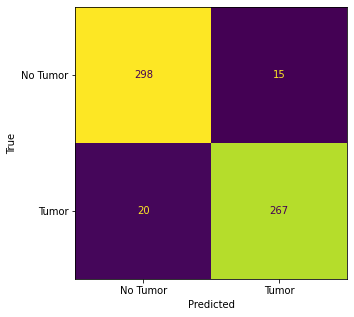

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)

## ResNet50

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/resnet/best_model')

In [ ]:
predictions = model.predict(X_test, verbose=True)
predictions = np.where(predictions > .5, 1, 0)

19/19 [==============================] - 3s 104ms/step


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

19/19 [==============================] - 3s 82ms/step - loss: 0.1059 - accuracy: 0.9800 - auc: 0.9886


In [ ]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       313
           1       0.99      0.97      0.98       287

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



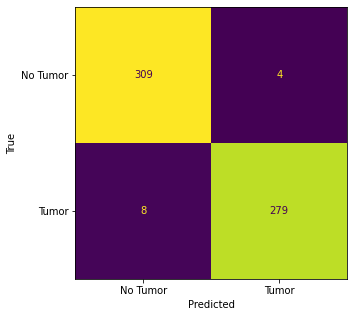

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)

## Vision transformer

In [ ]:
test = Dataset.from_pandas(test_df).cast_column("path", Image()).rename_column("path", "image")
dataset = DatasetDict()
dataset['test'] = test
dataset = dataset.rename_column("label", "labels")
dataset = dataset.class_encode_column("labels")

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
model_name_or_path = '/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/ViT/vit-training-output'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

dataset = dataset.with_transform(transform)

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
labels = dataset['test'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

In [ ]:
def compute_metrics(eval_pred: EvalPrediction):
  preds = np.argmax(eval_pred.predictions, axis=1)
  return {
    "acc": accuracy_score(eval_pred.label_ids, preds),
    "f1": f1_score(eval_pred.label_ids, preds),
    "precision": precision_score(eval_pred.label_ids, preds),
    "recall": recall_score(eval_pred.label_ids, preds)
    }

# arguments for Trainer
test_args = TrainingArguments(
  output_dir = "./vit-training-output",
  do_train = False,
  do_predict = True,
  per_device_eval_batch_size = 16,   
  dataloader_drop_last = False    ,
  fp16=True,
  remove_unused_columns=False
)

# init trainer
trainer = Trainer(
  model = model, 
  args = test_args, 
  compute_metrics = compute_metrics,
  data_collator = collate_fn,
  tokenizer = feature_extractor
)

Using cuda_amp half precision backend


In [ ]:
pred_output = trainer.predict(dataset['test'])
trainer.log_metrics("test", pred_output.metrics)

***** Running Prediction *****
  Num examples = 600
  Batch size = 16


***** test metrics *****
  test_acc                =      0.995
  test_f1                 =     0.9948
  test_loss               =     0.0189
  test_precision          =     0.9965
  test_recall             =      0.993
  test_runtime            = 0:00:07.92
  test_samples_per_second =      75.72
  test_steps_per_second   =      4.796


In [ ]:
preds = np.argmax(pred_output.predictions, axis=1)
print(metrics.classification_report(pred_output.label_ids, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       313
           1       1.00      0.99      0.99       287

    accuracy                           0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



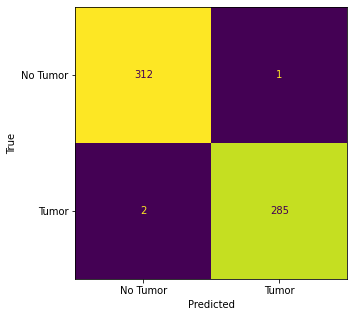

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=pred_output.label_ids, y_pred=preds, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)